In [1]:
import torch
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import torchtext

In [2]:
##Change working directory to talk-berty-to-me root
import os
os.chdir("D:/University/Projects/AML/talk-berty-to-me")

In [3]:
#Reading data from Project Gutenberg
data_gutenberg = pd.read_csv('data/books_and_genres.csv')

In [4]:
#Selecting relevant columns
data_gutenberg = data_gutenberg.loc[:,['title', 'text', 'genres']]
data_gutenberg.head(3)

,title,text,genres
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Di...","{'21st-century', 'history', 'roman', 'classics..."
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distr...","{'horror', 'mystery', 'classics', 'science-fic..."
2,the warriors,"Produced by Charles Aldarondo, Charlie Kirschn...","{'literary-fiction', 'history', 'biography', '..."


In [5]:
universal_set = set()
def parse_set(string_set):
    return ast.literal_eval(string_set)

for string in list(zip(data_gutenberg['genres'])):
    parsed_set = parse_set(string[0])
    universal_set = universal_set.union(parsed_set)
universal_set_list = list(universal_set)

In [6]:
# def OneHotEncodeGenres(genres):
#     return [1 if genre in genres else 0 for genre in universal_set_list]

# data_gutenberg.loc[:,'genre_one_hot'] = data_gutenberg['genres'].apply(lambda x: OneHotEncodeGenres(x))


In [7]:
for genre in universal_set_list:
    data_gutenberg[genre] = data_gutenberg['genres'].apply(lambda x: 1 if genre in x else 0)

data_gutenberg.drop(columns=['genres'], inplace=True)

C:\Users\setul\AppData\Local\Temp\ipykernel_43360\3779480420.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_gutenberg[genre] = data_gutenberg['genres'].apply(lambda x: 1 if genre in x else 0)


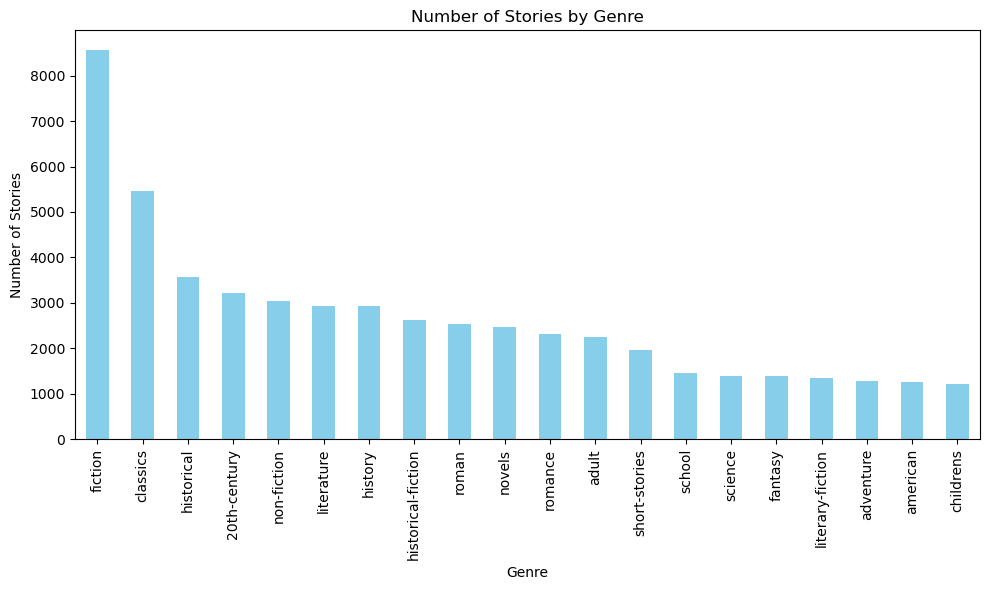

In [9]:
#Plotting number of stories by genre
genre_counts = data_gutenberg.drop(columns=['title','text']).sum().sort_values(ascending=False)[:20]
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Stories by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Stories')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

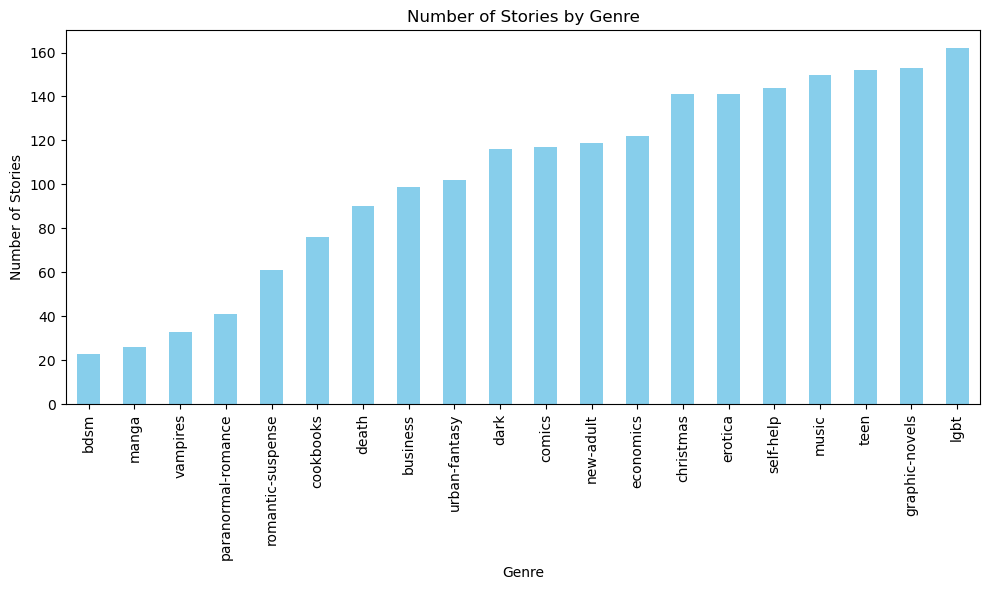

In [10]:
#Plotting number of stories by genre
genre_counts_low = data_gutenberg.drop(columns=['title','text']).sum().sort_values()[:20]
plt.figure(figsize=(10, 6))
genre_counts_low.plot(kind='bar', color='skyblue')
plt.title('Number of Stories by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Stories')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
top_7_cats = genre_counts.index[:7]

In [12]:
data_gutenberg = data_gutenberg.loc[:,['title', 'text'] + list(top_7_cats)]
data_gutenberg.head(3)

,title,text,fiction,classics,historical,20th-century,non-fiction,literature,history
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Di...",1,1,1,0,1,1,1
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distr...",1,1,0,1,0,1,0
2,the warriors,"Produced by Charles Aldarondo, Charlie Kirschn...",1,1,1,1,1,1,1


In [13]:
data_gutenberg = data_gutenberg.loc[
    data_gutenberg.loc[:, list(top_7_cats)].sum(axis=1)>0,:
]

In [6]:
#Building vocabulary
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter = iter(data_gutenberg.loc[:,'text'] + data_gutenberg.loc[:,'title'])
def yield_tokens(train_iter):
    for text in train_iter:
        if type(text) is not str:
            continue
        yield tokenizer(text)

In [15]:
vocab = build_vocab_from_iterator(
    yield_tokens(train_iter), specials=["<unk>"], min_freq=1000)

In [ ]:
vocab.set_default_index(vocab["<unk>"])

In [53]:
len(vocab)

25257

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\setul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\setul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
data_gutenberg.head(2)

,title,sentences,keywords,fiction,classics,historical,20th-century,non-fiction,history,literature
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Di...",[pg distributed proofreaders seneca apocolocyn...,1,1,1,0,1,1,1
0,apocolocyntosis,"ROUSE, M.A.",[rouse],1,1,1,0,1,1,1


In [8]:
from rake_nltk import Rake
r = Rake()
def rake_extract(text):
    r.extract_keywords_from_text(str(text))
    ranked_phrases_with_scores = r.get_ranked_phrases_with_scores()
    sorted_phrases = sorted(ranked_phrases_with_scores, key=lambda x: x[0], reverse=True)
    if len(sorted_phrases) == 0:
        return ""
    return sorted_phrases[0][1]

In [ ]:
data_gutenberg.loc[:,'sentences'] = data_gutenberg.loc[:,'text'].apply(lambda x: nltk.tokenize.sent_tokenize(str(x)))
data_gutenberg = data_gutenberg.explode('sentences')
data_gutenberg.loc[:,'keywords'] = data_gutenberg.loc[:,'sentences'].apply(lambda x: rake_extract(x))
data_gutenberg = data_gutenberg.loc[:,['title', 'sentences', 'keywords'] + list(top_7_cats)]

In [11]:
#Uncomment if file is to be exported
# import pyarrow
# data_gutenberg.to_parquet('data/data_gutenberg_13Feb.parquet')
# torch.save(vocab, 'data/vocab.pth')


In [2]:
#Uncomment if pre-processing is to be avoided and data is to be loaded from file
# data_gutenberg = pd.read_parquet('data/data_gutenberg_13Feb.parquet')
# vocab = torch.load('data/vocab.pth')
# vocab.set_default_index(vocab["<unk>"])

In [3]:
def collate_batch(batch):
    from torch.nn.utils.rnn import pad_sequence
    titles, sentences, keywords = zip(*batch)
    titles = [tokenizer(t) for t in titles]
    title_tensor = pad_sequence([torch.tensor(vocab.lookup_indices(t)) for t in titles],
                            batch_first=True)
    sentences = [tokenizer(s) for s in sentences]
    sentence_tensor = pad_sequence([torch.tensor(vocab.lookup_indices(s)) for s in sentences],
                              batch_first=True)
    
    keyword = [tokenizer(k) for k in keywords]
    keyword_tensor = pad_sequence([torch.tensor(vocab.lookup_indices(k)) for k in keyword],
                              batch_first=True)
    
    # tensor_list = []
    # for keyword_series in keywords:
    #     for keyword_row in keyword_series:
    #         tokenized_keys = tokenizer(keyword_row)
    #         tokenized_keys_tensor = torch.tensor(vocab.lookup_indices(tokenized_keys))
    #         tensor_list.append(tokenized_keys_tensor)
    # keyword_tensor = pad_sequence(torch.stack(tensor_list), batch_first=True)
            

    
    # tokenized_keywords = [[tokenizer(k) for k in kw] for kw in keywords]
    # keyword_tensor = pad_sequence([torch.tensor(vocab.lookup_indices(tokenized_kw)) for tokenized_kw in tokenized_keywords],
    #                                batch_first=True)
    
    return sentence_tensor, title_tensor, keyword_tensor



In [4]:
dataloader = torch.utils.data.DataLoader(data_gutenberg.loc[
    :,['title', 'sentences', 'keywords']].values, batch_size=8,
      shuffle=False, collate_fn=collate_batch)

In [8]:
for idx, (sentences, title, keywords) in enumerate(dataloader):
    print(sentences.shape, title.shape, keywords.shape)
    break

torch.Size([8, 42]) torch.Size([8, 1]) torch.Size([8, 5])
